# Hyperparams and Helpers

In [ ]:
# !wget -c "https://s3.amazonaws.com/dl4j-distribution/GoogleNews-vectors-negative300.bin.gz"
# !gunzip GoogleNews-vectors-negative300.bin.gz
! pip install ftfy regex tqdm
! pip install git+https://github.com/openai/CLIP.git

  Cloning https://github.com/openai/CLIP.git to /tmp/pip-req-build-0z8iitjt
  Running command git clone -q https://github.com/openai/CLIP.git /tmp/pip-req-build-0z8iitjt


In [ ]:
import cv2
import numpy as np
import pickle
import os
import itertools
import re
import tqdm
from PIL import Image

import torch 
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, TensorDataset, DataLoader
from torch.cuda.amp import GradScaler, autocast

from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences

from gensim.models import KeyedVectors
import random
from sklearn.model_selection import train_test_split
# random.seed(517)

import warnings
warnings.filterwarnings("ignore")
import matplotlib.pyplot as plt

import clip
clip.available_models()

['RN50', 'RN101', 'RN50x4', 'RN50x16', 'ViT-B/32', 'ViT-B/16']

In [ ]:
model, preprocess = clip.load("ViT-B/32")
model.cuda().eval()
input_resolution = model.visual.input_resolution
context_length = model.context_length
vocab_size = model.vocab_size

print("Model parameters:", f"{np.sum([int(np.prod(p.shape)) for p in model.parameters()]):,}")
print("Input resolution:", input_resolution)
print("Context length:", context_length)
print("Vocab size:", vocab_size)

Model parameters: 151,277,313
Input resolution: 224
Context length: 77
Vocab size: 49408


In [ ]:
# CLIP has some layers explicitly parameterized using fp16 values. We need to
# convert them back to fp32 in order to use automatic mixed-precision training
def convert_weights(model: nn.Module):
    """Convert applicable model parameters to fp32"""

    def _convert_weights_to_fp32(l):
        if isinstance(l, (nn.Conv1d, nn.Conv2d, nn.Linear)):
            l.weight.data = l.weight.data.float()
            if l.bias is not None:
                l.bias.data = l.bias.data.float()

        if isinstance(l, nn.MultiheadAttention):
            for attr in [*[f"{s}_proj_weight" for s in ["in", "q", "k", "v"]], "in_proj_bias", "bias_k", "bias_v"]:
                tensor = getattr(l, attr)
                if tensor is not None:
                    tensor.data = tensor.data.float()

        for name in ["text_projection", "proj"]:
            if hasattr(l, name):
                attr = getattr(l, name)
                if attr is not None:
                    attr.data = attr.data.float()

    model.apply(_convert_weights_to_fp32)

convert_weights(model)

In [ ]:
# Global Path Vairables
ROOT_DIR =  "drive/MyDrive/DecorAssist/IKEA/"
TEXT_DIR = ROOT_DIR + "text_data/"
ITEMS_DIR = ROOT_DIR + "images/all_items/"
ROOMS_DIR = ROOT_DIR + "images/room_scenes/"

# Global Parameter Variables
MAX_SEQUENCE_LENGTH = 100
NUM_WORDS_TOKENIZER = 50000
EMBEDDING_DIM = 300
BATCH_SIZE = 32
POSITIVE_SIZE = 1000 # We might only use a subset of the positive pairs
TRAIN_TEST_RATIO = 0.33

# Model Hyperparameters
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
LEARNING_RATE = 0.001 # 0.001
HIDDEN_DIM = 64 # 64
N_LAYERS = 8 # 2
EPOCHS = 5
CLIP = 5
DROPOUT = 0.5
TRAIN_WITH_ROOM_IMAGES = True

In [ ]:
def preprocess_img(path):
  img = cv2.imread(path)
  try:
    img = cv2.resize(img, (224, 224))
  except:
    print(path)
  img = img.astype(np.float32) / 255
  img = np.reshape(img, (3, 224 ,224))
  return img


def read_pickle(fn):
	with open(fn, "rb") as f:
		return pickle.load(f)
  

def clip_tokenize(texts):
  truncated_texts = [' '.join(text.split()[:50]) for text in texts]
  return clip.tokenize(truncated_texts)


# Train-val split that does not share products between training and validation sets.
def generate_product_limited_samples(products, all_positive_pairs, random_state=None):
    """
    Generates positive and negative examples for the given products using shared
    occurence in rooms to indicate whether two products are compatible.

    products: A sequence of product IDs; ALL positive and negative pairs must
        contain only these product IDs.
    all_positive_pairs: A set of product ID pairs that are positive.
    
    Returns: A tuple (x, y), where x is a sequence of product ID pairs and y is
        the array of [0 or 1] labels indicating presence in all_positive_pairs.
    """
    product_set = set(products)
    within_positive_pairs = [p for p in sorted(all_positive_pairs) if p[0] in product_set and p[1] in product_set]
    negative_pairs = random_negative_sampling(products, all_positive_pairs, count=len(within_positive_pairs), random_state=random_state)
    x = within_positive_pairs + negative_pairs
    y = np.array([1] * len(within_positive_pairs) + [0] * len(negative_pairs))
    if random_state is not None: np.random.seed(random_state)
    indices = np.random.permutation(np.arange(len(x)))
    return [x[i] for i in indices], y[indices]


def random_negative_sampling(products, all_positive_pairs, count=None, random_state=None):
  selected_negative_pairs = []
  if random_state is not None: random.seed(random_state)
  while len(selected_negative_pairs) < (count or len(all_positive_pairs)):
    random_pair = tuple(random.sample(products, 2))
    if random_pair in all_positive_pairs:
      continue
    else:
      selected_negative_pairs.append(random_pair)
  return selected_negative_pairs


def get_embedding_matrix(word_index, weights_path="/content/GoogleNews-vectors-negative300.bin"):
  word2vecDict = KeyedVectors.load_word2vec_format(weights_path, binary=True)
  embed_size = 300
  embeddings_index = dict()
  for word in word2vecDict.wv.vocab:
    embeddings_index[word] = word2vecDict.word_vec(word)
  print("Loaded " + str(len(embeddings_index)) + " word vectors.")
        
  embedding_matrix = 1 * np.random.randn(len(word_index)+1, embed_size)

  embeddedCount = 0
  for word, i in word_index.items():
    i-=1
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None: 
      embedding_matrix[i] = embedding_vector
      embeddedCount+=1
  print("total embedded:", embeddedCount, "common words")
  del(embeddings_index)
  return embedding_matrix

def preprocess_info(properties):
    base = properties["type"] + " " + properties["desc"]
    base = base.replace("View more product information", "")
#     matches = re.findall(product_names, base)
#     if matches: print(matches)
    base = re.sub(product_names, '', base)
    return re.sub(r'\s+', ' ', base)

In [ ]:
class CoLearnFurnitureImagePairsDataset(Dataset):
    """Dataset containing pairs of furniture items."""

    def __init__(self, pairs, room_ids, labels, item_path=ITEMS_DIR, room_path=ROOMS_DIR):
        """
        Args:
            image_path (string): Path to the directory containing images.
            pairs (list of tuples of strings): Pairs of image IDs to be used as training samples.
            labels (array of integers): Labels for the training samples.
        """
        super(CoLearnFurnitureImagePairsDataset, self).__init__()
        self.image_ids = list(set(x for pair in pairs for x in pair))
        self.room_ids = room_ids
        self.index_mapping = {image_id: i for i, image_id in enumerate(self.image_ids)}
        self.item_images = [preprocess_img(item_path + image_id + ".jpg") for image_id in tqdm.tqdm_notebook(self.image_ids)]
        self.room_images = [preprocess_img(room_path + room_id + ".jpg") for room_id in tqdm.tqdm_notebook(self.room_ids)]
        self.pairs = pairs
        self.labels = labels

    def __len__(self):
        return len(self.pairs)

    def __getitem__(self, idx):
      if torch.is_tensor(idx):
        idx = idx.tolist()

      if isinstance(idx, (list, tuple)):
        x1, x2, x3, y = zip(*[self[i] for i in idx])
        return torch.stack(x1), torch.stack(x2), torch.stack(x3), torch.from_numpy(np.array(y))
      
      pair = self.pairs[idx]
      return self.item_images[self.index_mapping[pair[0]]],\
              self.item_images[self.index_mapping[pair[1]]],\
              self.room_images[idx],\
              self.labels[idx]

# Load Venkat's Pre-built Dataset
#### After training the model for several epochs, stop, set TRAIN_WITH_ROOM_IMAGES to false, and re-create the dataset

In [ ]:
# {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
room_categories = read_pickle(TEXT_DIR + "categories_dict.p")
# {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
item_categories = read_pickle(TEXT_DIR + "categories_images_dict.p")
# {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
item_property = read_pickle(TEXT_DIR + "products_dict.p")
# {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
item_to_description = read_pickle(TEXT_DIR + "img_to_desc.p")
# {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
item_to_rooms_map = read_pickle(TEXT_DIR + "item_to_room.p")
item_to_rooms_map = {item_url.split("/")[-1].split(".jpg")[0] : val for item_url, val in item_to_rooms_map.items()}
# {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
room_to_item_categories = read_pickle(TEXT_DIR + "room_to_items.p")

room_to_items = {}
unavailable_scenes = set()
for item_id, room_url_list in item_to_rooms_map.items():
    if not os.path.exists(ITEMS_DIR + item_id + ".jpg"):
        print(ITEMS_DIR + item_id + ".jpg" + " does not exist")
        continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        if not os.path.exists(ROOT_DIR + "images/room_scenes/" + room_url):
            if room_id not in unavailable_scenes:
                # print(room_url + " does not exist")
                unavailable_scenes.add(room_id)

        if room_id not in room_to_items:
            room_to_items[room_id] = [item_id]
        else:
            room_to_items[room_id].append(item_id)

# all_positive_pairs = []
# for room, item_id_list in room_to_items.items():
#     pairs_for_current_room = list(set([tuple(sorted(x)) for x in itertools.combinations(set(room_to_items[room]), 2)])) # n choose 2
#     all_positive_pairs += pairs_for_current_room

product_names = "(" + "|".join(list(set([value["name"] for value in item_property.values()]))) + ")"
item_to_info = {key: preprocess_info(value) for key, value in item_property.items()} # remove view more info

drive/MyDrive/DecorAssist/IKEA/images/all_items/890.333.75.jpg does not exist
drive/MyDrive/DecorAssist/IKEA/images/all_items/991.333.98.jpg does not exist
drive/MyDrive/DecorAssist/IKEA/images/all_items/990.612.97.jpg does not exist


In [ ]:
with open(ROOT_DIR + "train_sets_reweighted.pkl", "rb") as f:
  train_sets = pickle.load(f)

with open(ROOT_DIR + "val_data_reweighted.pkl", "rb") as f:
  val_set = pickle.load(f)

# add empty image
for i in range(len(train_sets)):
  train_sets[i] = (train_sets[i][0], train_sets[i][1], ['empty' if v is None else v for v in train_sets[i][2]])

# The reason for using an if-else here is that
# we want the model to get rid of the reliance on room images in later epochs
train_pairs = train_sets[0][0]
y_train = train_sets[0][1]

if TRAIN_WITH_ROOM_IMAGES:
  train_room_ids = train_sets[0][2]
else:
  train_room_ids = ["empty" for _ in range(len(train_sets[0][2] ))]

val_pairs = val_set[0]
y_val = val_set[1]

In [ ]:
# train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
# train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
# tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
# tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)
# WORD_INDEX = tokenizer.word_index
# print('Found %s unique tokens.' % len(WORD_INDEX))
# print('Max len:', MAX_SEQUENCE_LENGTH)
# WORD2VEC_EMBEDDING_MATRIX = get_embedding_matrix(WORD_INDEX)

# X_train_text_premise = tokenizer.texts_to_sequences(train_premise_texts)
# X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

# X_train_text_hypothesis = tokenizer.texts_to_sequences(train_hypothesis_texts)
# X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

# val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
# val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]

# # Please notice that: tokenizer is ONLY used on training set to build vocab
# X_val_text_premise = tokenizer.texts_to_sequences(val_premise_texts)
# X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

# X_val_text_hypothesis = tokenizer.texts_to_sequences(val_hypothesis_texts)
# X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
X_train_text_premise = clip_tokenize(train_premise_texts)
X_train_text_hypothesis = clip_tokenize(train_hypothesis_texts)

val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]
X_val_text_premise = clip_tokenize(val_premise_texts)
X_val_text_hypothesis = clip_tokenize(val_hypothesis_texts)

In [ ]:
X_train_image = CoLearnFurnitureImagePairsDataset(pairs=train_pairs, 
                                           room_ids=train_room_ids, 
                                           labels=y_train)

X_val_image = CoLearnFurnitureImagePairsDataset(pairs=val_pairs, 
                                         room_ids=["empty" for _ in range(len(val_pairs))],
                                         labels=y_val)

  0%|          | 0/1379 [00:00<?, ?it/s]

  0%|          | 0/27716 [00:00<?, ?it/s]

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/6244 [00:00<?, ?it/s]

In [ ]:
img_train_data = X_train_image
# text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise), torch.from_numpy(X_train_text_hypothesis), torch.from_numpy(y_train))
text_train_data = TensorDataset(X_train_text_premise, X_train_text_hypothesis, torch.from_numpy(y_train))

img_val_data = X_val_image
# text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise), torch.from_numpy(X_val_text_hypothesis), torch.from_numpy(y_val))
text_val_data = TensorDataset(X_val_text_premise, X_val_text_hypothesis, torch.from_numpy(y_val))

text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

print(len(text_train_loader), len(img_train_loader))
print(len(text_val_loader), len(img_val_loader))

867 867
196 196


# From Scratch Build Train and Eval Set (Don't run this!)

#### Load raw data

In [ ]:
# # {room image url -> string of room category}; e.g.: 'ikea-town-and-country__1364308377063-s4.jpg': 'Living Room'
# room_categories = read_pickle(TEXT_DIR + "categories_dict.p")
# # {item image ID -> string of item category}; e.g.: '291.292.29': 'Footstool',
# item_categories = read_pickle(TEXT_DIR + "categories_images_dict.p")
# # {item image id -> dict of descriptions}; e.g. '202.049.06': {'color': 'Grey,black','desc': 'View more product information Concealed press studs keep the quilt in place','img': 'images/objects/202.049.06.jpg','name': 'GURLI','size': '120x180 cm','type': 'Throw'},
# item_property = read_pickle(TEXT_DIR + "products_dict.p")
# # {item image url -> {description, name}}; e.g: '/static/images/902.592.50.jpg': {'desc': 'The high pile dampens sound and provides a soft surface to walk on.','name': 'GSER'},
# item_to_description = read_pickle(TEXT_DIR + "img_to_desc.p")
# # {item image url -> list of corresponding room image url}; e.g.: 'images/001.509.85.jpg': ['images/room_scenes/ikea-wake-up-and-grow__1364335362013-s4.jpg','images/room_scenes/ikea-wake-up-and-grow-1364335370196.jpg'],
# item_to_rooms_map = read_pickle(TEXT_DIR + "item_to_room.p")
# # {room image url -> list of items}; e.g.: 'ikea-work-from-home-in-perfect-harmony__1364319311386-s4.jpg': ['desk','chair']
# room_to_item_categories = read_pickle(TEXT_DIR + "room_to_items.p")

# # Some simple preprossing
# item_to_info = {key : value["type"] + " " +
#                              value["desc"]
#                        for key, value in item_property.items()} # remove view more info

# room_to_items = {}

# for item_url, room_url_list in item_to_rooms_map.items():
#   item_id = item_url.split("/")[-1].split(".jpg")[0]
#   if not os.path.exists(ITEMS_DIR + item_id + ".jpg"):
#       print(item_url + " does not exist")
#       continue

#   for room_url in room_url_list:
#     room_id = room_url.split("/")[-1].split(".jpg")[0]
#     if room_id not in room_to_items:
#       room_to_items[room_id] = [item_id]
#     else:
#       room_to_items[room_id].append(item_id)

images/890.333.75.jpg does not exist
images/991.333.98.jpg does not exist
images/990.612.97.jpg does not exist


#### Construct positive and negative pairs

For IR-style problem, seen and unseen can be tricky. We need to discuss whether unseen means "unseen pairs" or "unseen image or text"

In [ ]:
# all_positive_pairs = set()
# for room, item_id_list in room_to_items.items():
#   pairs_for_current_room = list(itertools.combinations(room_to_items[room], 2)) # n choose 2
#   all_positive_pairs |= set(pairs_for_current_room)

# all_products = sorted(set([x for pair in all_positive_pairs for x in pair]))
# train_products, val_products = train_test_split(all_products, test_size=TRAIN_TEST_RATIO, random_state=72)

# train_pairs, y_train = generate_product_limited_samples(train_products, all_positive_pairs, random_state=72)
# val_pairs, y_val = generate_product_limited_samples(val_products, all_positive_pairs, random_state=72)
# print(len(train_pairs), len(val_pairs))

# # with open(ROOT_DIR + "train_data.pkl", "wb") as file:
# #     pickle.dump((train_pairs, y_train), file)
# # with open(ROOT_DIR + "val_data.pkl", "wb") as file:
# #     pickle.dump((val_pairs, y_val), file)

21666 5810


In [ ]:
# # To read the training and validation sets
# with open(ROOT_DIR + "train_data.pkl", "rb") as file:
#     train_pairs, y_train = pickle.load(file)
# with open(ROOT_DIR + "val_data.pkl", "rb") as file:
#     val_pairs, y_val = pickle.load(file)

#### Build PyTorch dataloader for train/val image/text

In [ ]:
# X_train_image = FurnitureImagePairsDataset(ITEMS_DIR, train_pairs, y_train)
# X_val_image = FurnitureImagePairsDataset(ITEMS_DIR, val_pairs, y_val)

NameError: ignored

In [ ]:
# train_premise_texts = [item_to_info[id] for id, _ in train_pairs]
# train_hypothesis_texts = [item_to_info[id] for _, id in train_pairs]
# tokenizer = Tokenizer(num_words=NUM_WORDS_TOKENIZER, lower=True)
# tokenizer.fit_on_texts(train_premise_texts + train_hypothesis_texts)
# WORD_INDEX = tokenizer.word_index
# print('Found %s unique tokens.' % len(WORD_INDEX))
# print('Max len:', MAX_SEQUENCE_LENGTH)
# WORD2VEC_EMBEDDING_MATRIX = get_embedding_matrix(WORD_INDEX)

# X_train_text_premise = tokenizer.texts_to_sequences(train_premise_texts)
# X_train_text_premise = pad_sequences(X_train_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

# X_train_text_hypothesis = tokenizer.texts_to_sequences(train_hypothesis_texts)
# X_train_text_hypothesis = pad_sequences(X_train_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# val_premise_texts = [item_to_info[id] for id, _ in val_pairs]
# val_hypothesis_texts = [item_to_info[id] for _, id in val_pairs]

# # Please notice that: tokenizer is ONLY used on training set to build vocab
# X_val_text_premise = tokenizer.texts_to_sequences(val_premise_texts)
# X_val_text_premise = pad_sequences(X_val_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

# X_val_text_hypothesis = tokenizer.texts_to_sequences(val_hypothesis_texts)
# X_val_text_hypothesis = pad_sequences(X_val_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

In [ ]:
# # img_train_data = TensorDataset(torch.from_numpy(X_train_image_premise), torch.from_numpy(X_train_image_hypothesis), torch.from_numpy(y_train))
# img_train_data = X_train_image
# text_train_data = TensorDataset(torch.from_numpy(X_train_text_premise), torch.from_numpy(X_train_text_hypothesis), torch.from_numpy(y_train))

# # img_val_data = TensorDataset(torch.from_numpy(X_val_image_premise), torch.from_numpy(X_val_image_hypothesis), torch.from_numpy(y_val))
# img_val_data = X_val_image
# text_val_data = TensorDataset(torch.from_numpy(X_val_text_premise), torch.from_numpy(X_val_text_hypothesis), torch.from_numpy(y_val))

# text_train_loader = DataLoader(text_train_data, batch_size=BATCH_SIZE)
# img_train_loader = DataLoader(img_train_data, batch_size=BATCH_SIZE)

# text_val_loader = DataLoader(text_val_data, batch_size=BATCH_SIZE)
# img_val_loader = DataLoader(img_val_data, batch_size=BATCH_SIZE)

# print(len(text_train_loader), len(img_train_loader))
# print(len(text_val_loader), len(img_val_loader))

# Define Model

In [ ]:
class CNN_LSTM_CoLearn(nn.Module):
  def __init__(self, vocab_size, weights_matrix, n_hidden, n_layers, n_out):
    super(CNN_LSTM_CoLearn, self).__init__()

    # LSTM for the text overview
    self.vocab_size, self.n_hidden, self.n_out, self.n_layers = vocab_size, n_hidden, n_out, n_layers
    num_embeddings, embedding_dim = weights_matrix.shape[0], weights_matrix.shape[1]
    self.emb = nn.Embedding(num_embeddings, embedding_dim)
    self.emb.weight.data.copy_(torch.from_numpy(weights_matrix))
    self.emb.weight.requires_grad = True
    self.lstm = nn.LSTM(embedding_dim, self.n_hidden, self.n_layers, dropout=0.2, batch_first=True)
    self.dropout = nn.Dropout(DROPOUT)
    self.lstm_fc = nn.Linear(self.n_hidden, 128)
    # self.sigmoid = nn.Sigmoid()

    # CNN for the posters
    self.conv1 = nn.Conv2d(3, 32, 3)
    self.max_pool1 = nn.MaxPool2d(2)
    self.conv2 = nn.Conv2d(32, 64, 3)
    self.max_pool2 = nn.MaxPool2d(2)
    self.conv3 = nn.Conv2d(64, 128, 3)
    self.max_pool3 = nn.MaxPool2d(2)
    self.conv4 = nn.Conv2d(128, 128, 3)
    self.max_pool4 = nn.MaxPool2d(2)
    self.cnn_dropout = nn.Dropout(0.1)
    self.cnn_fc = nn.Linear(5 * 5 * 128, 512)

    # Concat layer for the combined feature space
    # self.combined_fc1 = nn.Linear(640, 256)
    self.combined_fc1 = nn.Linear(512*3 + 128*2, 256)
    self.combined_fc2 = nn.Linear(256, 128)
    self.output_fc = nn.Linear(128, n_out)

  def lstm_encoder(self, lstm_inp):
    batch_size = lstm_inp.size(0)
    hidden = self.init_hidden(batch_size)
    lstm_inp = lstm_inp.long()
    embeds = self.emb(lstm_inp)
    lstm_out, hidden = self.lstm(embeds, hidden)
    lstm_out = self.dropout(lstm_out[:, -1])
    lstm_out = F.relu(self.lstm_fc(lstm_out))
    return lstm_out

  def cnn_encoder(self, cnn_inp):
    x = F.relu(self.conv1(cnn_inp))
    x = self.max_pool1(x)
    x = F.relu(self.conv2(x))
    x = self.max_pool2(x)
    x = F.relu(self.conv3(x))
    x = self.max_pool3(x)
    x = F.relu(self.conv4(x))
    x = self.max_pool4(x)
    x = x.view(-1, 5 * 5 * 128)
    x = self.cnn_dropout(x)
    cnn_out = F.relu(self.cnn_fc(x))
    return cnn_out

  def forward(self, lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3):
    cnn_out1, cnn_out2, cnn_out3 = self.cnn_encoder(cnn_inp1), self.cnn_encoder(cnn_inp2), self.cnn_encoder(cnn_inp3)
    lstm_out1, lstm_out2 = self.lstm_encoder(lstm_inp1), self.lstm_encoder(lstm_inp2)
    combined_inp = torch.cat((cnn_out1, cnn_out2, cnn_out3, lstm_out1, lstm_out2), 1)
    x_comb = F.relu(self.combined_fc1(combined_inp))
    x_comb = F.relu(self.combined_fc2(x_comb))
    out = self.output_fc(x_comb)
    return out

  def init_hidden(self, batch_size):
    weight = next(self.parameters()).data
    hidden = (weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE),
                      weight.new(self.n_layers, batch_size, self.n_hidden).zero_().to(DEVICE))
    return hidden


class CLIPIKEA_Colearn(nn.Module):
    def __init__(self, clip_model, embedding_dim, n_out):
        super(CLIPIKEA_Colearn, self).__init__()

        self.clip_model = clip_model
        self.combined_fc1 = nn.Linear(embedding_dim * 5, 256)
        self.output_fc = nn.Linear(256, n_out)


    def embedder(self, txt, img):
      with autocast(enabled=False):
        txt_emb = self.clip_model.encode_text(txt)
        img_emb = self.clip_model.encode_image(img)
      return txt_emb, img_emb


    def classifier(self, txt_emb_1, txt_emb_2, img_emb_1, img_emb_2, img_emb_3):
      all_emb = torch.cat((txt_emb_1, txt_emb_2, img_emb_1, img_emb_2, img_emb_3), 1)
      x_comb = F.relu(self.combined_fc1(all_emb))
      out = self.output_fc(x_comb)
      return out


    def forward(self, txt_1, txt_2, img_1, img_2, img_3):
      batch_size = txt_1.size(0)

      txt_emb_1, img_emb_1 = self.embedder(txt_1, img_1)
      txt_emb_2, img_emb_2 = self.embedder(txt_2, img_2)
      img_emb_3 = self.clip_model.encode_image(img_3)

      out = self.classifier(txt_emb_1, txt_emb_2, img_emb_1, img_emb_2, img_emb_3)
      return out

#### Don't re-run this cell after training with room images

In [ ]:
output_size = 1 # only output a single sigmoid value # y.shape[1]
print(output_size)

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

full_model = CLIPIKEA_Colearn(model, 512, output_size)
full_model.to(device)

lr=0.001
# criterion = nn.MultiLabelSoftMarginLoss()
criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
optimizer = torch.optim.Adam(full_model.parameters(), lr=lr, weight_decay=1e-5)

# print("Currently using device: {}\n".format(DEVICE))

# model = CNN_LSTM_CoLearn(len(WORD_INDEX)+1, WORD2VEC_EMBEDDING_MATRIX, HIDDEN_DIM, N_LAYERS, 1)
# model.to(DEVICE)
# print("Model Architecture {}\n".format(model))

# lr= LEARNING_RATE
# criterion = nn.BCEWithLogitsLoss() # this means the sigmoid is INCORPORATED into the loss!!
# optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=1e-5)

1
cuda


#### Re-run the following cell after you re-create the dataset

In [ ]:
# CHECKPOINT_DIR = "/content/drive/MyDrive/coursework/mmml/DecorAssistant/baselines/clip_checkpoints/"
# CHECKPOINT_PREFIX = "first_run"

# torch.save(full_model.state_dict(), CHECKPOINT_DIR + "{}_initial_state.p".format(CHECKPOINT_PREFIX))

In [ ]:
grad_clip = 5
epochs = 1

for p in full_model.clip_model.parameters():
    p.requires_grad = False
for p in full_model.clip_model.get_submodule("token_embedding").parameters():
    p.requires_grad = True

# Scale gradients to use fp16 training
scaler = GradScaler()

full_model.train()
for i in range(epochs):
    total_acc_train = 0
    total_loss_train = 0

    for lstm, cnn in tqdm.tqdm_notebook(zip(text_train_loader, img_train_loader), total=len(text_train_loader)):
        lstm_inp1, lstm_inp2, lstm_labels = lstm
        cnn_inp1, cnn_inp2, cnn_inp3, cnn_labels = cnn
        
        with autocast():
            lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(device), lstm_inp2.to(device), lstm_labels.to(device)
            cnn_inp1, cnn_inp2, cnn_inp3, cnn_labels = cnn_inp1.to(device), cnn_inp2.to(device), cnn_inp3.to(device), cnn_labels.to(device)
            full_model.zero_grad()
            output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3)
            loss = criterion(output.squeeze(), lstm_labels.half())
        
        scaler.scale(loss).backward()
        
        scaler.unscale_(optimizer)
        # nn.utils.clip_grad_norm_(full_model.parameters(), grad_clip)
        scaler.step(optimizer)
        scaler.update()

        with torch.no_grad():
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_train += acc
            total_loss_train += loss.item()
    
    train_acc = total_acc_train/len(text_train_loader)
    train_loss = total_loss_train/len(text_train_loader)
    full_model.eval()
    total_acc_val = 0
    total_loss_val = 0

    with torch.no_grad():
        for lstm, cnn in tqdm.tqdm_notebook(zip(text_val_loader, img_val_loader), total=len(text_val_loader)):
            lstm_inp1, lstm_inp2, lstm_labels = lstm
            cnn_inp1, cnn_inp2, cnn_inp3, cnn_labels = cnn
            lstm_inp1, lstm_inp2, lstm_labels = lstm_inp1.to(device), lstm_inp2.to(device), lstm_labels.to(device)
            cnn_inp1, cnn_inp2, cnn_inp3, cnn_labels = cnn_inp1.to(device), cnn_inp2.to(device), cnn_inp3.to(device), cnn_labels.to(device)
            full_model.zero_grad()
            output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3)
            val_loss = criterion(output.squeeze(), lstm_labels.float())
            acc = torch.abs(torch.round(torch.sigmoid(output.squeeze())) - lstm_labels.float()).view(-1)
            acc = (1. - acc.sum() / acc.size()[0])
            total_acc_val += acc
            total_loss_val += val_loss.item()
    val_acc = total_acc_val/len(text_val_loader)
    val_loss = total_loss_val/len(text_val_loader)
    print(f'Epoch {i+1}: train_loss: {train_loss:.4f} train_acc: {train_acc:.4f} | val_loss: {val_loss:.4f} val_acc: {val_acc:.4f}')
    full_model.train()
    #torch.cuda.empty_cache()
    # torch.save(full_model.state_dict(), CHECKPOINT_DIR + "{}_epoch_{}.p".format(CHECKPOINT_PREFIX, i))

NameError: ignored

In [ ]:
torch.save(full_model.state_dict(), ROOT_DIR + "co-learn.p")

# Embedding Generation

In [ ]:
full_model.load_state_dict(torch.load(ROOT_DIR + "co-learn.p"))

<All keys matched successfully>

In [ ]:
val_image_ids = sorted(list(set([x for pair in val_pairs for x in pair])))
print(len(val_image_ids))
# emb_product_idx_mapping = {id: i for i, id in enumerate(val_image_ids)}
# combs = list(itertools.product(range(len(val_image_ids)), range(len(val_image_ids))))
# print(len(combs))
ranking_pairs = list(itertools.combinations(val_image_ids, 2)) # n choose 2

680


In [ ]:
len(ranking_pairs)

230860

In [ ]:
X_rank_image = CoLearnFurnitureImagePairsDataset(pairs=ranking_pairs, 
                                         room_ids=["empty" for _ in range(len(ranking_pairs))],
                                         labels=np.zeros(len(ranking_pairs)))

X_rank_text_premise = [item_to_info[id] for id, _ in ranking_pairs]
X_rank_text_hypothesis = [item_to_info[id] for _, id in ranking_pairs]
X_rank_text_premise = clip_tokenize(X_rank_text_premise)
X_rank_text_hypothesis = clip_tokenize(X_rank_text_hypothesis)

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/230860 [00:00<?, ?it/s]

In [ ]:
img_ranking_data = X_rank_image
text_ranking_data = TensorDataset(X_rank_text_premise, X_rank_text_hypothesis, torch.zeros(len(ranking_pairs)))

text_ranking_loader = DataLoader(text_ranking_data, batch_size=BATCH_SIZE)
img_ranking_loader = DataLoader(img_ranking_data, batch_size=BATCH_SIZE)

print(len(text_ranking_loader), len(img_ranking_loader))

79 79


In [ ]:
full_model.eval()
ranking_results = []
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm_notebook(zip(text_ranking_loader, img_ranking_loader), total=len(text_ranking_loader)):
      lstm_inp1, lstm_inp2, _ = lstm
      cnn_inp1, cnn_inp2, cnn_inp3, _ = cnn
      lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
      cnn_inp1, cnn_inp2, cnn_inp3 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_inp3.to(DEVICE)
      model.zero_grad()
      output = full_model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3)
      score = output.squeeze().cpu().detach().numpy().tolist()
      ranking_results.append(score)
ranking_results = np.concatenate(ranking_results).reshape(len(val_image_ids), len(val_image_ids))
print(ranking_results.shape)

  0%|          | 0/79 [00:00<?, ?it/s]

(50, 50)


In [ ]:
# embs = ... # matrix of embeddings for all products
# model = ... # a classification model that takes two arguments: a batch of "first" embeddings and a batch of "second" embeddings


# def make_batches(iterable, n=1):
#     l = len(iterable)
#     for ndx in range(0, l, n):
#         yield iterable[ndx:min(ndx + n, l)]
        
# results_list = []
# with torch.no_grad():
#     for batch in tqdm.tqdm(make_batches(combs, 32), total=len(combs) // 32 + 1):
#       first_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[0]]]] for x in batch]))
#       second_embs = torch.from_numpy(np.stack([embs[emb_product_idx_mapping[val_image_ids[x[1]]]] for x in batch]))
#       results_list.append(model(first_embs, second_embs).cpu().numpy())
# results = np.concatenate(results_list).reshape(len(val_image_ids), len(val_image_ids))
# results = 1 / (1 + np.exp(-results)) # optional sigmoid transformation (if not applied by model)

# Ranker

In [ ]:
def single_pair_inference(premise_image_path, hypothesis_image_path, premise_text, hypothesis_text, model, tokenizer, threshold, do_plot=False):
  premise_sequence = tokenizer.texts_to_sequences([premise_text])
  premise_sequence = pad_sequences(premise_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  hypothesis_sequence = tokenizer.texts_to_sequences([hypothesis_text])
  hypothesis_sequence = pad_sequences(hypothesis_sequence, maxlen=MAX_SEQUENCE_LENGTH)
  image_premise, image_hypothesis, image_empty = preprocess_img(premise_image_path), preprocess_img(hypothesis_image_path), preprocess_img(ROOMS_DIR + "empty.jpg")

  if do_plot:
    image_1 = Image.open(premise_image_path)
    image_2 = Image.open(hypothesis_image_path)
    fig = plt.figure(figsize=(15, 15))
    ax1 = fig.add_subplot(2,2,1)
    ax1.imshow(image_1)
    ax2 = fig.add_subplot(2,2,2)
    ax2.imshow(image_2)
    print("Left item description ------ {}".format(premise_text))
    print("Right item description ------  {}".format(hypothesis_text))


  image_premise = np.reshape(image_premise, (1, 3, 224, 224))
  image_hypothesis = np.reshape(image_hypothesis, (1, 3, 224, 224))
  image_empty = np.reshape(image_empty, (1, 3, 224, 224))

  img_data = TensorDataset(torch.from_numpy(image_premise), torch.from_numpy(image_hypothesis), torch.from_numpy(image_empty))
  text_data = TensorDataset(torch.from_numpy(premise_sequence), torch.from_numpy(hypothesis_sequence))
  
  text_loader = DataLoader(text_data, batch_size=1)
  img_loader = DataLoader(img_data, batch_size=1)

  for lstm, cnn in zip(text_loader, img_loader):
    lstm_inp1, lstm_inp2 = lstm
    cnn_inp1, cnn_inp2, cnn_inp3 = cnn
    lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
    cnn_inp1, cnn_inp2, cnn_inp3 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_inp3.to(DEVICE)
    model.zero_grad()
    output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3)

  score = output.squeeze().cpu().detach().numpy().tolist()
  if score > threshold:
    return "Positive", score
  else:
    return "Negative", 1 - score


Left item description ------ Bowl Dinnerware that combines a simple, rustic design with a soft ruffled edge. It allows you to coordinate with other porcelain to get different characters in your table settings.
Right item description ------  Chair with armrests, outdoor Use wood stain, outdoor use when re-staining the furniture, sold separately. You can stack up to four chairs on top of each other, which makes them easy to store.
Actual Label for this pair is Positive
The prediction for this pair is Negative with confidence 1.0


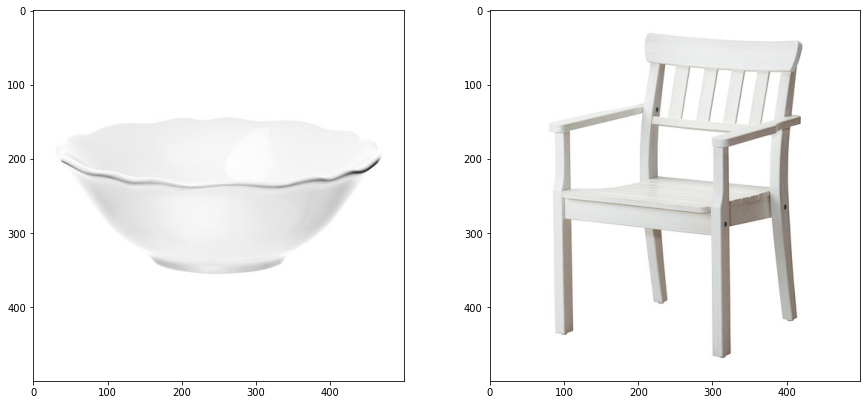

In [ ]:
random_index = random.randint(0, len(train_pairs))
image_id_1 = train_pairs[random_index][0]
image_id_2 = train_pairs[random_index][1]
text_1 = train_premise_texts[random_index]
text_2 = train_hypothesis_texts[random_index]
prediction, confidence = single_pair_inference(premise_image_path=ITEMS_DIR + image_id_1 + ".jpg",
          hypothesis_image_path=ITEMS_DIR + image_id_2 + ".jpg",
          premise_text=text_1,
          hypothesis_text=text_2,
          model=model,
          tokenizer=tokenizer,
          threshold=0.4,
          do_plot=True)
print("Actual Label for this pair is", "Positive" if y_train[random_index] == 1 else "Negative")
print("The prediction for this pair is", prediction, "with confidence", confidence)

# Rank Evaluation

In [ ]:
# Build pairs to rank
NUM_QUERIES = 50

val_products = sorted(list(set(x for pair in val_pairs for x in pair)))

np.random.seed(1234)
premise_products = np.random.choice(val_products, size=min(NUM_QUERIES, len(val_products)), replace=False)
hypothesis_products = val_products

ranking_pairs = list(itertools.product(premise_products, hypothesis_products))
print(len(ranking_pairs), "pairs,", len(hypothesis_products), "products per query")

34000 pairs, 680 products per query


In [ ]:
# Get the ground-truth

ground_truth_map = {}
for item_url, room_url_list in item_to_rooms_map.items():
    item_id = item_url.split("/")[-1].split(".jpg")[0]
    if item_id not in premise_products: continue

    for room_url in room_url_list:
        room_id = room_url.split("/")[-1].split(".jpg")[0]
        ground_truth_map[item_id] = ground_truth_map.get(item_id, set()) | set(room_to_items[room_id])
ground_truth_lists = [ground_truth_map[item_id] for item_id in premise_products]


In [ ]:
X_rank_image = CoLearnFurnitureImagePairsDataset(pairs=ranking_pairs, 
                                         room_ids=["empty" for _ in range(len(ranking_pairs))],
                                         labels=np.zeros(len(ranking_pairs)))

X_rank_text_premise = [item_to_info[id] for id, _ in ranking_pairs]
X_rank_text_premise = tokenizer.texts_to_sequences(X_rank_text_premise)
X_rank_text_premise = pad_sequences(X_rank_text_premise, maxlen=MAX_SEQUENCE_LENGTH)

X_rank_text_hypothesis = [item_to_info[id] for _, id in ranking_pairs]
X_rank_text_hypothesis = tokenizer.texts_to_sequences(X_rank_text_hypothesis)
X_rank_text_hypothesis = pad_sequences(X_rank_text_hypothesis, maxlen=MAX_SEQUENCE_LENGTH)

  0%|          | 0/680 [00:00<?, ?it/s]

  0%|          | 0/34000 [00:00<?, ?it/s]

In [ ]:
img_ranking_data = X_rank_image
text_ranking_data = TensorDataset(torch.from_numpy(X_rank_text_premise), torch.from_numpy(X_rank_text_hypothesis), torch.zeros(len(ranking_pairs)))

text_ranking_loader = DataLoader(text_ranking_data, batch_size=BATCH_SIZE)
img_ranking_loader = DataLoader(img_ranking_data, batch_size=BATCH_SIZE)

print(len(text_ranking_loader), len(img_ranking_loader))

1063 1063


In [ ]:
model.eval()
ranking_results = []
with torch.no_grad():
    for lstm, cnn in tqdm.tqdm_notebook(zip(text_ranking_loader, img_ranking_loader), total=len(text_ranking_loader)):
      lstm_inp1, lstm_inp2, _ = lstm
      cnn_inp1, cnn_inp2, cnn_inp3, _ = cnn
      lstm_inp1, lstm_inp2 = lstm_inp1.to(DEVICE), lstm_inp2.to(DEVICE)
      cnn_inp1, cnn_inp2, cnn_inp3 = cnn_inp1.to(DEVICE), cnn_inp2.to(DEVICE), cnn_inp3.to(DEVICE)
      model.zero_grad()
      output = model(lstm_inp1, lstm_inp2, cnn_inp1, cnn_inp2, cnn_inp3)
      score = output.squeeze().cpu().detach().numpy().tolist()
      ranking_results.append(score)
ranking_results = np.concatenate(ranking_results).reshape(len(premise_products), len(hypothesis_products))
print(ranking_results.shape)

  0%|          | 0/1063 [00:00<?, ?it/s]

(50, 680)


In [ ]:
import math
class Evaluator:
    def __init__(self, GroundTruth):
      self.GroundTruth = GroundTruth

    def NDCG_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      DCGScore = 0
      result = []
      for i, item in enumerate(sortedRankResult[:topk]):
        if item[0] in self.GroundTruth:
          result.append((item, i))
      DCGScore = sum([item[0][1]/math.log(item[1]+2, 2) for item in result])
      IDCGScore = sum([1/math.log(i+2,2) for i in range(topk)])
      NDCG = DCGScore / IDCGScore

      return NDCG
    
    def Score_Eval(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      return sum(i[1] for i in sortedRankResult[:topk] if i[0] in self.GroundTruth) / topk
    
    def Precision(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(topkresult)

    def Recall(self, rankresult, topk):
      sortedRankResult = sorted(rankresult.items(), key = lambda x:x[1], reverse=True)
      topkresult = sortedRankResult[:topk]
      return len([i for i in sortedRankResult[:topk] if i[0] in self.GroundTruth]) / len(self.GroundTruth)
    
    def FValue(self, rankresult, topk):
      precision = self.Precision(rankresult, topk)
      recall = self.Recall(rankresult, topk)
      return 2 * precision * recall / (precision + recall) if precision + recall > 0 else 0

In [ ]:
# Now use the evaluator
TOP_K = 10

ndcg = np.zeros(len(premise_products))
score = np.zeros(len(premise_products))
precision = np.zeros(len(premise_products))
recall = np.zeros(len(premise_products))
fvalue = np.zeros(len(premise_products))
for i, (ground_truth, rankings) in enumerate(zip(ground_truth_lists, ranking_results)):
    evaluator = Evaluator(ground_truth)
    rankings = {product: output for product, output in zip(hypothesis_products, rankings)}
    ndcg[i] = evaluator.NDCG_Eval(rankings, TOP_K)
    score[i] = evaluator.Score_Eval(rankings, TOP_K)
    precision[i] = evaluator.Precision(rankings, TOP_K)
    recall[i] = evaluator.Recall(rankings, TOP_K)
    fvalue[i] = evaluator.FValue(rankings, TOP_K)
print("NDCG: {:.4f} (95% CI {:.3f}-{:.3f})".format(ndcg.mean(), ndcg.mean() - 1.96 * ndcg.std(), ndcg.mean() + 1.96 * ndcg.std()))
print("Score: {:.4f} (95% CI {:.3f}-{:.3f})".format(score.mean(), score.mean() - 1.96 * score.std(), score.mean() + 1.96 * score.std()))
print("Precision: {:.4f} (95% CI {:.3f}-{:.3f})".format(precision.mean(), precision.mean() - 1.96 * precision.std(), precision.mean() + 1.96 * precision.std()))
print("Recall: {:.4f} (95% CI {:.3f}-{:.3f})".format(recall.mean(), recall.mean() - 1.96 * recall.std(), recall.mean() + 1.96 * recall.std()))
print("FValue: {:.4f} (95% CI {:.3f}-{:.3f})".format(fvalue.mean(), fvalue.mean() - 1.96 * fvalue.std(), fvalue.mean() + 1.96 * fvalue.std()))

NDCG: 0.0000 (95% CI -0.000-0.000)
Score: 0.0000 (95% CI -0.000-0.000)
Precision: 0.0060 (95% CI -0.041-0.053)
Recall: 0.0021 (95% CI -0.017-0.021)
FValue: 0.0029 (95% CI -0.023-0.029)
